In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.circuit.library import C3XGate
# import basic plot tools
from qiskit.visualization import plot_histogram

import mplhep
plt.style.use(mplhep.style.LHCb2)  # CMS or ATLAS/LHCb

In [8]:
def initialize_s(qc, num_qubit, num_matching):
    """Apply a H-gate to 'qubits' in qc"""
    qc.x(num_qubit - 1)
    qc.h(num_qubit - 1)
    
    for q in range(num_matching):
        qc.h(q)
    #qc.reset(num_qubit)
    #qc.h(num_qubit)
    
    return qc

In [9]:
def compare_node1_node2(qc):
    #qc = QuantumCircuit(11)
    qc.barrier([0, 1, 2, 3, 4])
    qc.cx(0, 1)
    qc.barrier(0)
    qc.cx(1, 2)
    qc.barrier([0, 1])
    qc.x(2)
    qc.barrier([0, 1])
    qc.cx(2, 3)
    qc.barrier([0])
    qc.barrier([0, 1])
    qc.x(2)
    qc.cx(1, 2)
    qc.cx(0, 1)
    #oracle_edge12 = qc.to_gate()
    #oracle_edge12.name = "edge12"
    #qc.draw()
    return qc

In [10]:
def diffuser(qc, nqubits):
    #qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    qc.barrier(list(range(nqubits-1)))
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    #U_s = qc.to_gate()
    #U_s.name = "diffuser"
    return qc

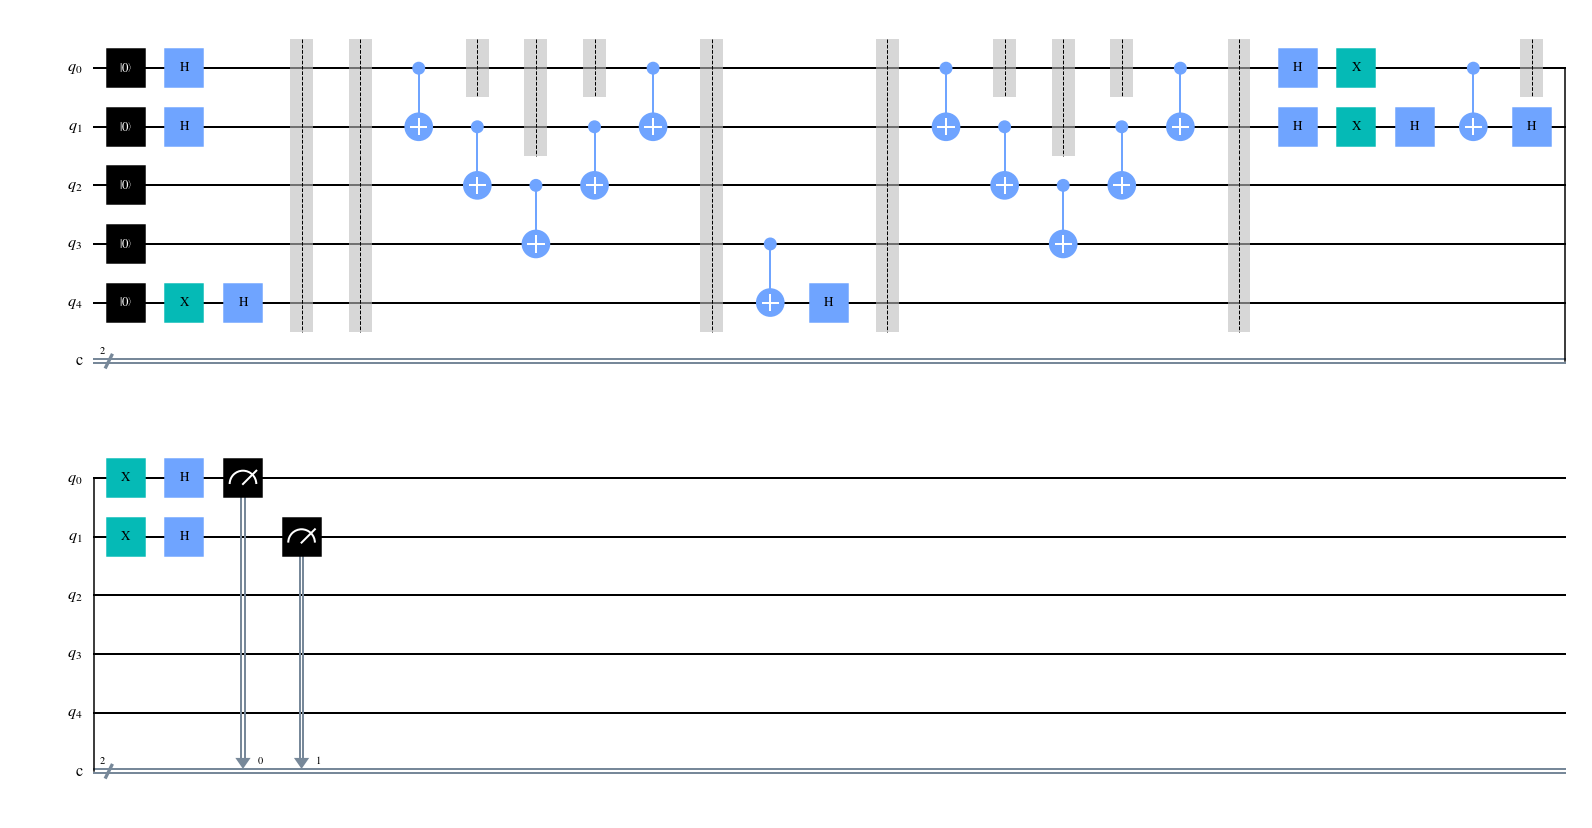

In [13]:
n_qubit = 5
n_matching = 2
grover_circuit = QuantumCircuit(n_qubit, n_matching)
grover_circuit.reset(range(0, n_qubit))
grover_circuit = initialize_s(grover_circuit, n_qubit, n_matching)
grover_circuit.barrier([0, 1, 2, 3, 4])
for i in range(1):
    #grover_circuit.rx(pi/4, 0)
    grover_circuit = compare_node1_node2(grover_circuit)
    grover_circuit.barrier([0, 1, 2, 3, 4])
    grover_circuit.mcx([3], 4)
    grover_circuit.h([4])
    grover_circuit = compare_node1_node2(grover_circuit) 
    grover_circuit.barrier([0, 1, 2, 3, 4])
    grover_circuit = diffuser(grover_circuit, 2)
    #grover_circuit.rx(-pi/4, 0)
grover_circuit.measure([0, 1], [0, 1])
grover_circuit.draw(output = "mpl")

In [14]:
from qiskit import BasicAer, Aer,execute
from qiskit.providers.aer import AerSimulator
sim = Aer.get_backend('aer_simulator')


In [15]:
job = execute(grover_circuit, backend = sim, shots = 25600)
counts = job.result().get_counts()

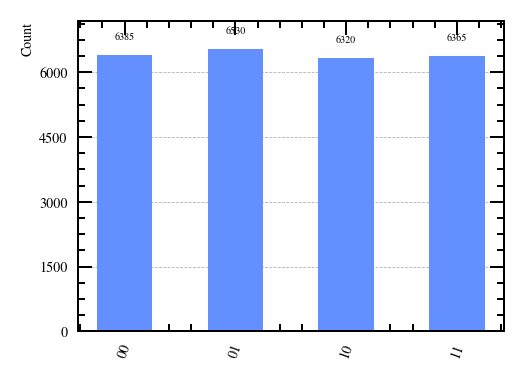

In [16]:
plot_histogram(counts)